<a href="https://colab.research.google.com/github/Rafly-Aziz/Tugas-Besar-AI-130-141/blob/main/Tubes_141_130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/content/drive/MyDrive/UAS/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


In [6]:
base_dir = '/tmp/Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')


In [7]:
NORMAL_train_path = train_dir + '/NORMAL'
PNEUMONIA_train_path = train_dir + '/PNEUMONIA'
NORMAL_val_path = val_dir + '/NORMAL'
PNEUMONIA_val_path = val_dir + '/PNEUMONIA'


NORMAL_len_train = len(os.listdir(NORMAL_train_path))
PNEUMONIA_len_train = len(os.listdir(PNEUMONIA_train_path))
NORMAL_len_val = len(os.listdir(NORMAL_val_path))
PNEUMONIA_len_val = len(os.listdir(PNEUMONIA_val_path))

print("jumlah dataset Training : ", NORMAL_len_train + PNEUMONIA_len_train)
print("jumlah dataset validasi : ", NORMAL_len_val + PNEUMONIA_len_val)
print("\n\n")
print("jumlah train kelas NORMAL : ", NORMAL_len_train)
print("jumlah train kelas PNEUMONIA : ", PNEUMONIA_len_train)
print("jumlah validasi kelas NORMAL : ", NORMAL_len_val)
print("jumlah validasi kelas PNEUMONIA : ", PNEUMONIA_len_val)

jumlah dataset Training :  148
jumlah dataset validasi :  40



jumlah train kelas NORMAL :  74
jumlah train kelas PNEUMONIA :  74
jumlah validasi kelas NORMAL :  20
jumlah validasi kelas PNEUMONIA :  20


In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')


Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [10]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
'''
definisikan dan setting callback untuk :
1. memantau performa model
2. melakukan save model terbaik menggunakan model checkpoint
3. memberhentikan pelatihan ketika tidak memnuhi syarat dalam parameter earlystopping
'''

callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Colab Notebooks/TugasBesar/model_drop_batch_weight_from_callback_2.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [12]:
'''
definisikan pretrained model yang ingin digunakan
'''

VGG16_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', #include_top = false , berarti fully connected layer akan dipidah dari arsitektur
                                                 input_tensor=None, input_shape=(224, 224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

VGG16_base.trainable = False

In [14]:
'''
mendefinisikan layer pada bagian fully connected layer
'''

print('Adding new layers')
output = VGG16_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [15]:
VGG16_model = Model(VGG16_base.input, output)

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [ ]:
history = VGG16_model.fit(
      train_generator,
      steps_per_epoch=7,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=2,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

Epoch 1/100
2/7 [=======>......................] - ETA: 50s - loss: 0.1673 - accuracy: 0.9250 

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [20]:
# loading model to evaluate more depth
from keras.models import load_model
model_path =  '/content/gdrive/MyDrive/Colab Notebooks/TugasBesar/model_drop_batch_weight_from_callback_2.h5'
model = load_model(model_path)

Found 40 images belonging to 2 classes.


<ipython-input-21-331da65692ed>:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=test_generator)


Accuracy  : 0.975
Precision : 0.9761904761904763
f1Score : 0.9749843652282676
[[19  1]
 [ 0 20]]


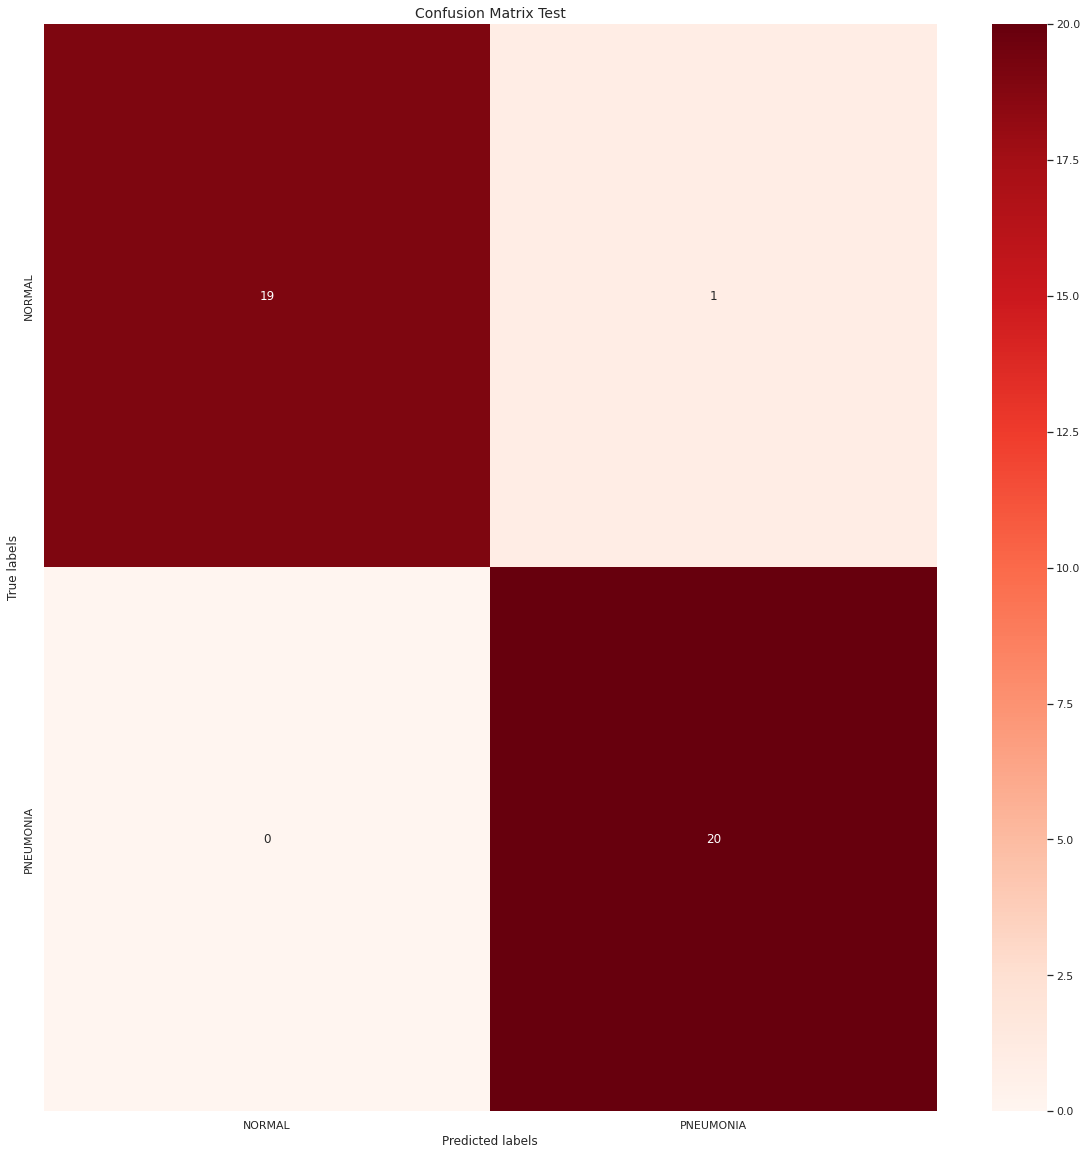

In [21]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = val_dir

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(20,20))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       1.00      0.95      0.97        20
   PNEUMONIA       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

